In [ ]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud

import expectile_neural_dual
import potentials
from ott.tools import sinkhorn_divergence

import jax
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import scipy
import numpy as np

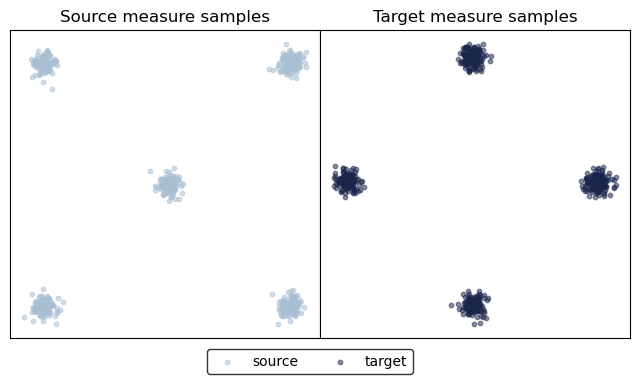

In [6]:

num_samples_visualize = 512
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = datasets.create_gaussian_mixture_samplers(
    name_source="square_five",
    name_target="square_four",
    valid_batch_size=num_samples_visualize,
    train_batch_size=2048,
)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

def plot_eval_samples(
    eval_data_source, eval_data_target, transported_samples=None
):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
        label="source",
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
        label="target",
    )
    axs[1].set_title("Target measure samples")

    if transported_samples is not None:
        axs[1].scatter(
            transported_samples[:, 0],
            transported_samples[:, 1],
            color="#F2545B",
            s=10,
            alpha=0.5,
            label="pushforward of source",
        )

    fig.legend(
        **{
            "ncol": (3 if transported_samples is not None else 2),
            "loc": "upper center",
            "bbox_to_anchor": (0.5, 0.1),
            "edgecolor": "k",
        }
    )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, ax


fig, ax = plot_eval_samples(eval_data_source, eval_data_target)
display(fig)
plt.close(fig)


# Expectile Neural Dual

Training iteration: 15000/90001
Neural dual distance between source and target data: 21.38


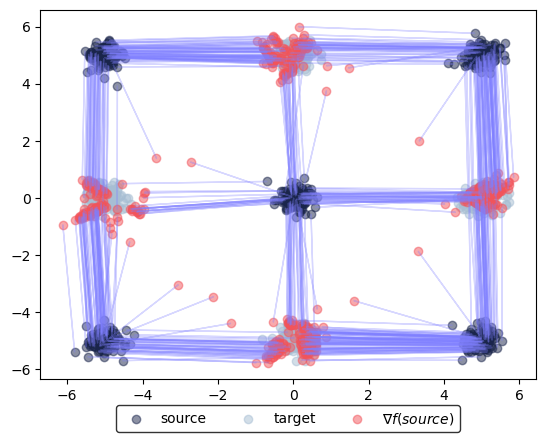

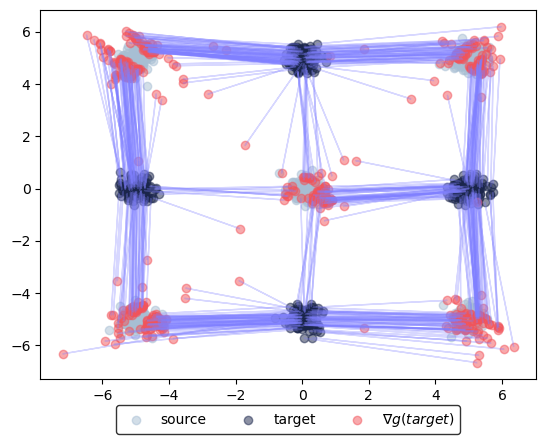

KeyboardInterrupt: 

In [7]:
num_train_iters = 90_001


def training_callback(step, learned_potentials):
    if step % 2500 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            eval_data_source, eval_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

neural_f = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)
neural_g = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.98,
    expectile_loss_coef=0.25,
    rng=jax.random.key(5),
    is_bidirectional=True,
    use_dot_product=False,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)


In [18]:

@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence

C = scipy.spatial.distance.cdist(eval_data_source, eval_data_target)
C = C / C.max()
geom = Geometry(C)
ot_problem = linear_problem.LinearProblem(geom)
solver = sinkhorn.Sinkhorn()
ot_solution = solver(ot_problem)
P_sinkhorn = ot_solution.matrix

# Barycentric projection on Target (Sinkhorn)
pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target

print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target_sinkhorn, eval_data_target):.2f}"
)

# Barycentric projection on Source (Sinkhorn)
pred_source = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn.T @ eval_data_source

print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")


Sinkhorn distance between target predictions and data samples: 6.21
Sinkhorn distance between source predictions and data samples: 8.62
Sinkhorn distance between source and target data: 20.89


On device: cpu
Iteration: 0


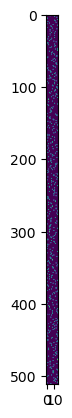

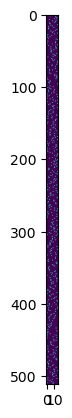

tensor([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
       dtype=torch.float64)
Next level cluster capacity: 32
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 32, Y: 32 [=capacity]
Length of assignment sets X: 3

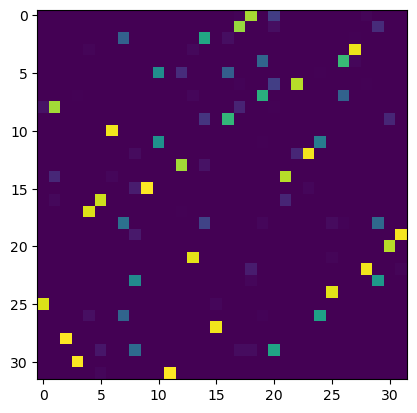

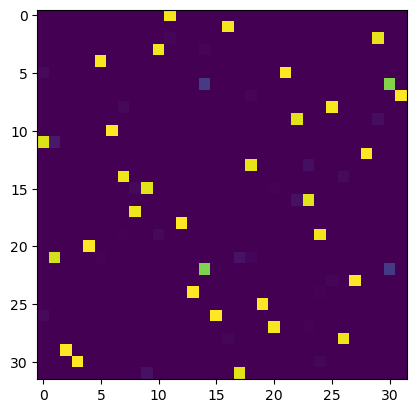

tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0313,
        0.0313, 0.0313, 0.0313, 0.0312, 0.0312, 0.0313, 0.0312, 0.0313, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0313, 0.0313, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

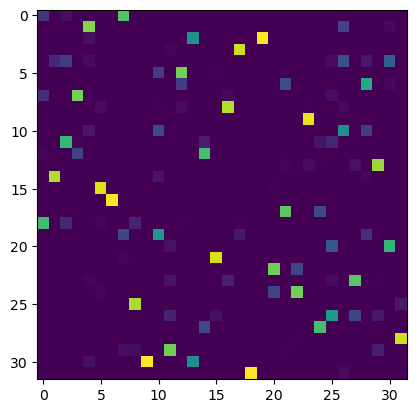

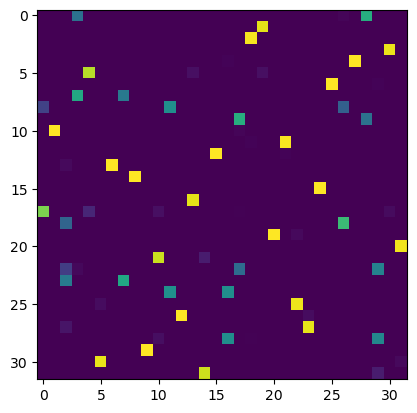

tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0313, 0.0313], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

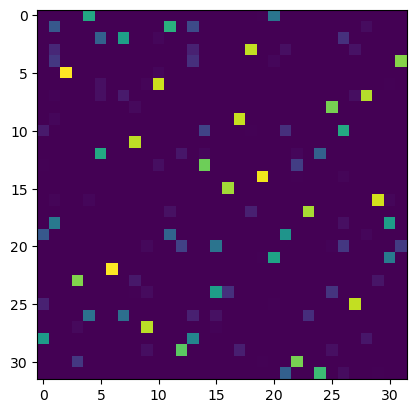

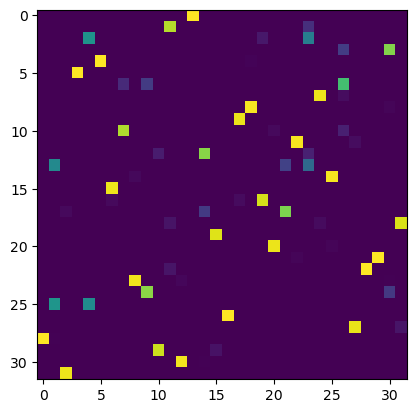

tensor([0.0312, 0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0313], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

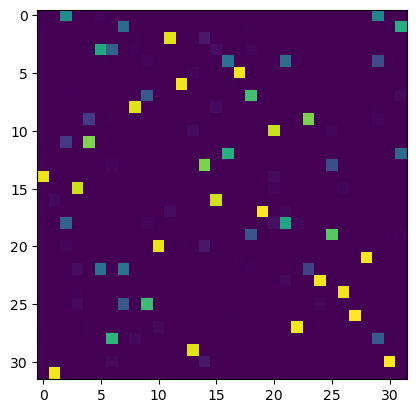

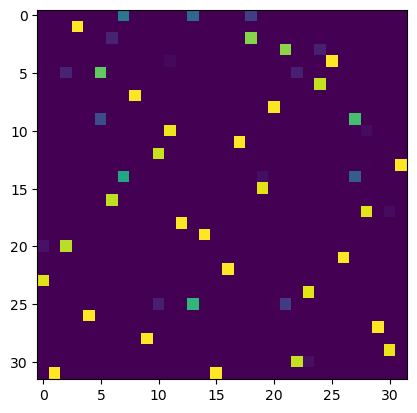

tensor([0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0313, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

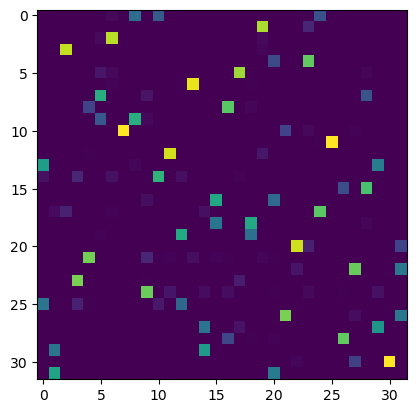

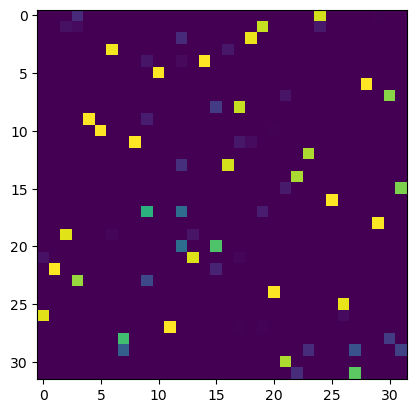

tensor([0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0313, 0.0313, 0.0313, 0.0313, 0.0312, 0.0312, 0.0313,
        0.0313, 0.0313, 0.0312, 0.0313, 0.0313], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

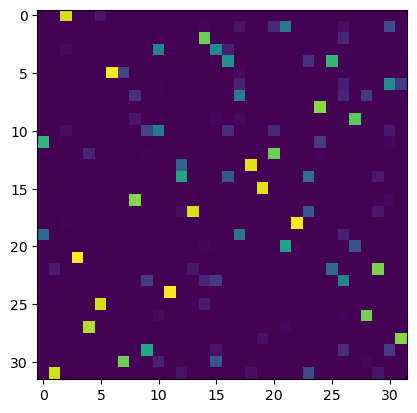

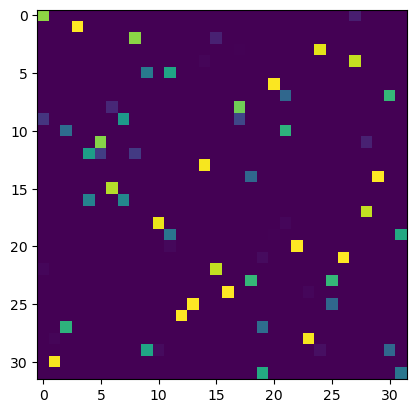

tensor([0.0313, 0.0313, 0.0312, 0.0312, 0.0313, 0.0313, 0.0313, 0.0313, 0.0312,
        0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0313, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

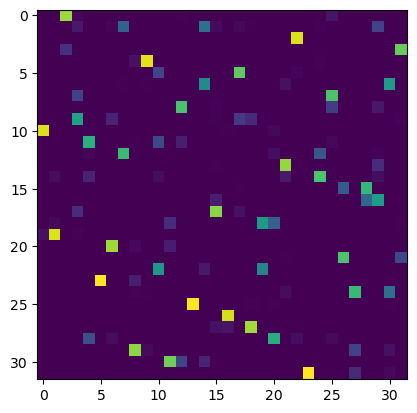

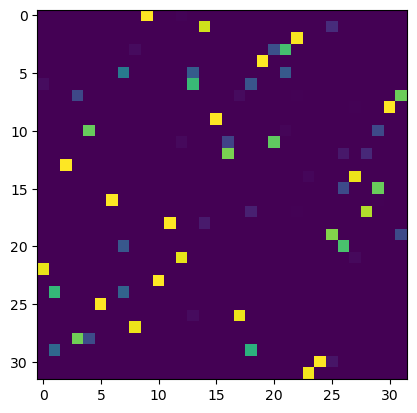

tensor([0.0313, 0.0313, 0.0312, 0.0312, 0.0313, 0.0312, 0.0313, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0312, 0.0312, 0.0313, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

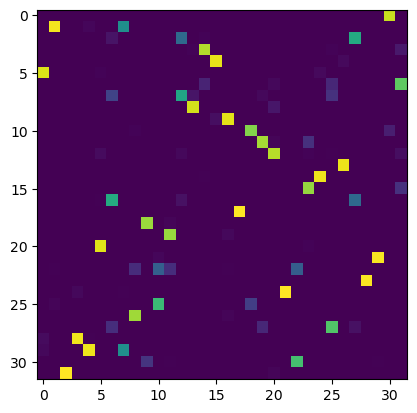

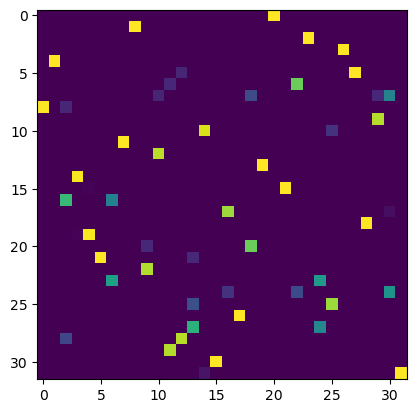

tensor([0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0313, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

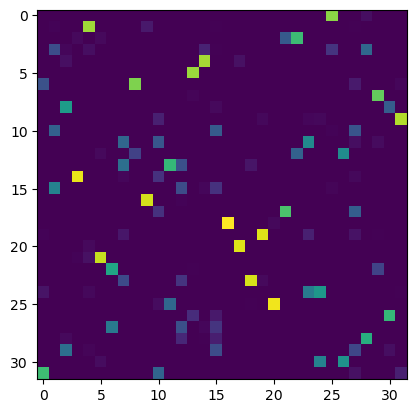

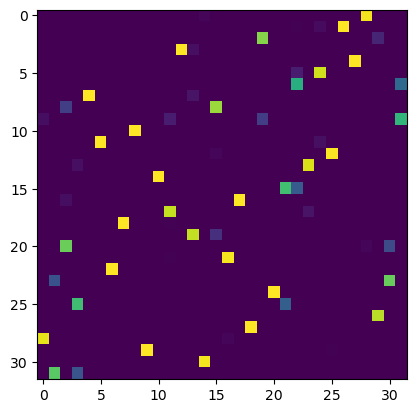

tensor([0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0312, 0.0313, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

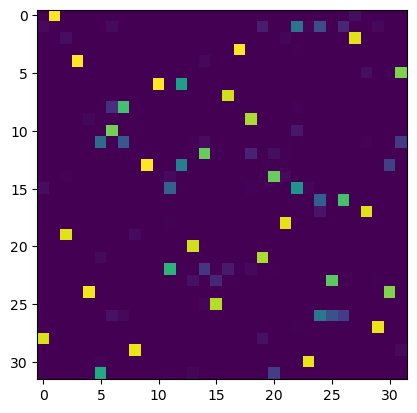

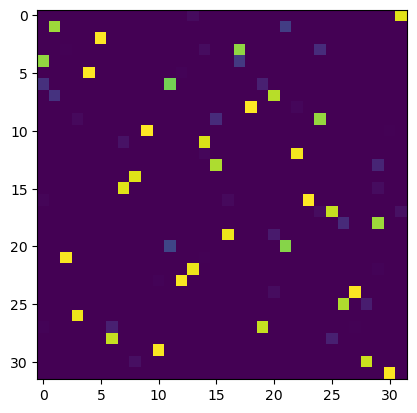

tensor([0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0313, 0.0313, 0.0313,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

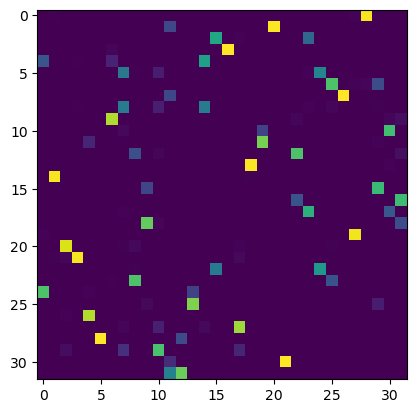

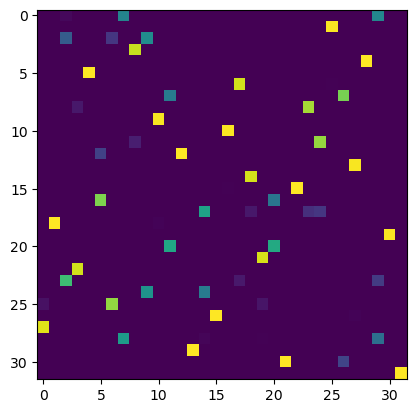

tensor([0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0313, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

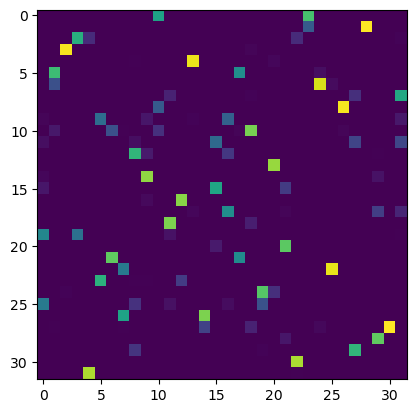

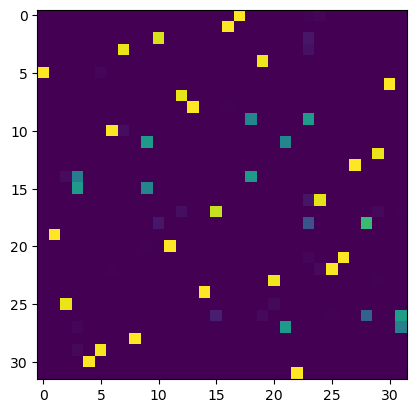

tensor([0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312,
        0.0313, 0.0313, 0.0312, 0.0313, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312,
        0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0313, 0.0312, 0.0313], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

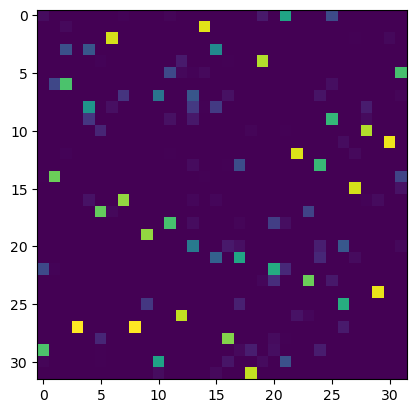

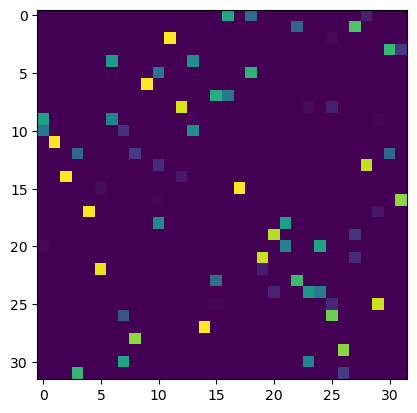

tensor([0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312,
        0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0312, 0.0312, 0.0313, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

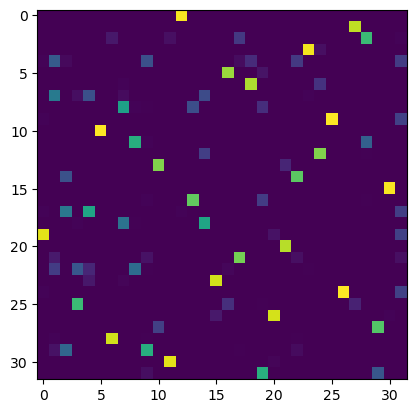

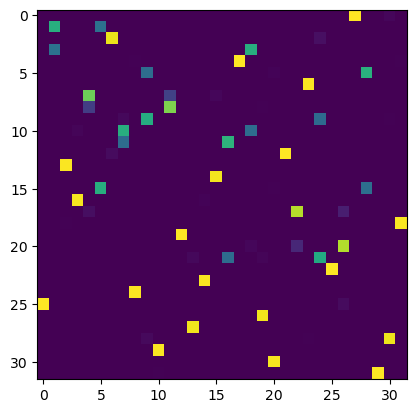

tensor([0.0312, 0.0312, 0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0313, 0.0313,
        0.0312, 0.0312, 0.0313, 0.0312, 0.0313, 0.0313, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0313, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

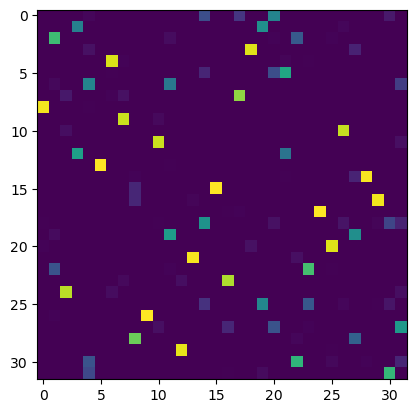

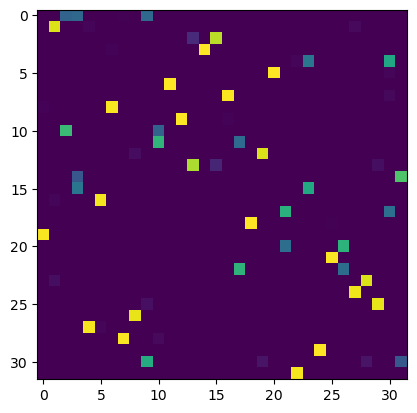

tensor([0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0313, 0.0312, 0.0313, 0.0312, 0.0313,
        0.0313, 0.0313, 0.0313, 0.0312, 0.0313], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

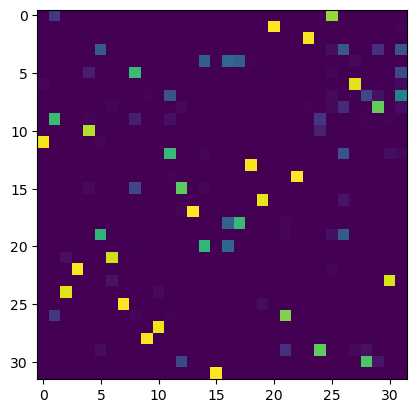

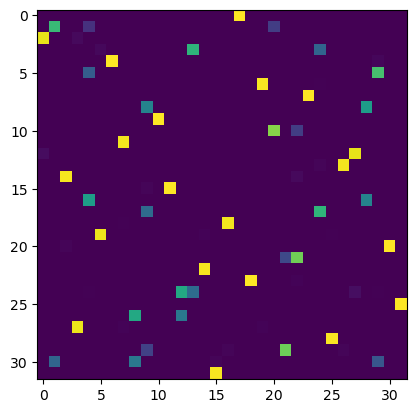

tensor([0.0312, 0.0313, 0.0312, 0.0313, 0.0312, 0.0313, 0.0312, 0.0312, 0.0313,
        0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0313, 0.0312,
        0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0312, 0.0313, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312], dtype=torch.float64)
Next level cluster capacity: 1
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment sets X: 1, Y: 1 [=capacity]
Length of assignment s

In [24]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
sys.path.insert(0, '../src/')
import importlib
import FRLC
from FRLC import FRLC_opt
import HR_OT
importlib.reload(HR_OT)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64


importlib.reload(HR_OT)

X = torch.from_numpy( np.array(eval_data_source) ).type(torch.DoubleTensor).to(device)
Y = torch.from_numpy( np.array(eval_data_target) ).type(torch.DoubleTensor).to(device)

rank_schedule = [16, 32]

P = HR_OT.hierarchical_refinement(X, Y, \
                                  torch.tensor(rank_schedule), FRLC_opt, \
                                  device=device, base_rank=1,
                                 return_as_coupling=True)



In [25]:
print( (P * C).sum() )
print( (P_sinkhorn * C).sum() )

tensor(0.3584, dtype=torch.float64)
0.3727626


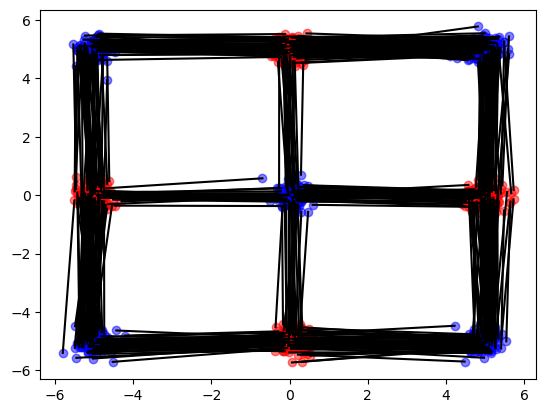

In [30]:
for idx1 in range(P.shape[0]):
    idx2 = int(np.argmax(P[idx1, :])) # only 1 index
    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]
    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()

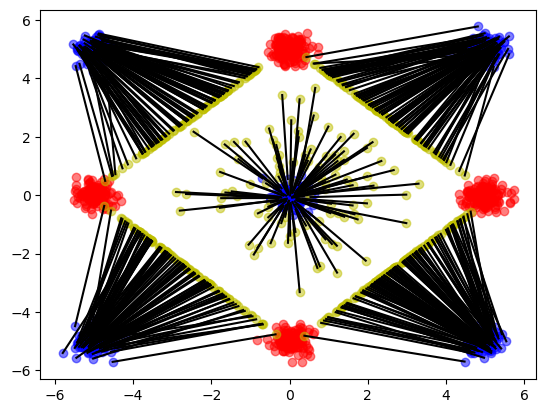

In [32]:
pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target

for idx1 in range(P_sinkhorn.shape[0]):
    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]
    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Initial points', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Final points', alpha=0.5)
plt.scatter(pred_target_sinkhorn[:,0], pred_target_sinkhorn[:,1], c='y', label=r'Barycentric projection', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()
